In [1]:
import cv2
import os
import numpy as np
from FlagRep import FlagRep

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

def load_avi_files(directory):
    avi_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.avi'):
            avi_files.append(os.path.join(directory, filename))
    return avi_files


def read_avi_to_numpy(file_path):
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print(f"Error opening video file: {file_path}")
        return None

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()

    # Convert list of frames to a NumPy array
    return np.array(frames)



In [2]:
import tqdm

directory = '../data/weizmann/'  # Change to your directory

dataset = []
mod_labels = []
for class_name in tqdm.tqdm(os.listdir(directory)):
    f_path = os.path.join(directory, class_name)
    avi_files = load_avi_files(f_path)
    data = [read_avi_to_numpy(avi_file) for avi_file in avi_files]
    dataset += data
    mod_labels += [class_name]*len(data)

    

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 34.73it/s]


In [3]:
fewest_frame_count = np.min([len(d) for d in dataset])
_,n_rows, n_cols  = dataset[0].shape

trimmed_dataset = []
for d in dataset:
    n_frames = len(d)
    d_trimmed = d[n_frames//2-fewest_frame_count//2:n_frames//2+fewest_frame_count//2,:,:]
    trimmed_dataset.append(d_trimmed)

In [4]:
n_rows, n_cols

(144, 180)

In [5]:
d = trimmed_dataset[0]

In [6]:
center_row = n_rows//2
center_col = n_cols//2

quarter_row = n_rows//4
quarter_col = n_cols//4

In [7]:
center_row = n_rows//2
center_col = n_cols//2

quarter_row = n_rows//4
quarter_col = n_cols//4

X = []
for d in trimmed_dataset:
    ss1 = d[:,n_rows//4:3*n_rows//4, n_cols//4:3*n_cols//4]
    ss2_mask = np.zeros((n_rows, n_cols), dtype=bool)
    # Set the outer pixels to True
    ss2_mask[:3*n_rows//4, :] = True  # Top
    ss2_mask[-n_rows//4:, :] = True  # Bottom
    ss2_mask[:, :3*n_cols//4] = True  # Left
    ss2_mask[:, -n_cols//4:] = True  # Right
    ss2 = d[:,ss2_mask]

    ss1 = ss1.reshape(ss1.shape[0], -1)
    ss2 = ss2.reshape(ss2.shape[0], -1)

    d_flat = np.hstack([ss1,ss2])


    X.append(d_flat)

ss_sizes = [ss1.shape[1], ss1.shape[1]+ss2.shape[1]]

In [8]:
ss_sizes

[6480, 32400]

In [9]:
As = [np.arange(sz) for sz in ss_sizes]
As

[array([   0,    1,    2, ..., 6477, 6478, 6479]),
 array([    0,     1,     2, ..., 32397, 32398, 32399])]

In [10]:
X[0].shape

(28, 32400)

In [11]:
doo = FlagRep(X[0], As, eps_rank = .95)

In [12]:
doo[0].shape, doo[1]

((28, 18), array([ 1, 18]))

In [13]:
Aset = As
eps_rank = 95

In [14]:
flags = {}
flags['FlagRep'] = []
flags['QR'] = []

flag_types = {}
flag_types['FlagRep'] = []
flag_types['QR'] = []
for m in tqdm.tqdm(X):
    frep, frep_ftype = FlagRep(m, As, eps_rank=eps_rank)
    flags['FlagRep'].append(frep)
    flag_types['FlagRep'].append(frep_ftype)

    qr ,_= np.linalg.qr(m)
    flags['QR'].append(qr)
    flag_types['QR'].append(list(np.arange(1,fewest_frame_count)))

100%|██████████| 93/93 [00:17<00:00,  5.32it/s]


In [15]:
from FlagRep import chordal_distance

def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

n_pts = len(flags['FlagRep'])
dist_mats = {}
for method_name in ['FlagRep', 'QR']:
    #make distance matrices
    dist_mats[method_name] = np.zeros((n_pts,n_pts))
    for i in tqdm.tqdm(range(n_pts)):
        for j in range(i+1,n_pts):
            x = flags[method_name][i]
            y = flags[method_name][j]
            fl_type_x = flag_types[method_name][i]
            fl_type_y = flag_types[method_name][j]
            Bs_x = make_Bs(fl_type_x)
            Bs_y = make_Bs(fl_type_y)
            dist = chordal_distance(x, y, Bs_x, Bs_y)
            dist_mats[method_name][i,j] = dist
            dist_mats[method_name][j,i] = dist
            

100%|██████████| 93/93 [00:03<00:00, 26.00it/s]


(array([[-1.93022902e-01,  2.80599558e-01,  1.24625473e-01,
          9.08321914e-02,  1.36175336e-01,  2.84324430e-02,
         -9.50414805e-02,  6.90870161e-02, -2.37484904e-01,
          1.34442506e-01, -6.57064887e-02, -3.80573888e-02,
          6.71488571e-02, -7.82097149e-02,  3.40145724e-01,
          5.68910939e-01, -2.13213513e-02, -3.63077821e-02,
          7.39610269e-02,  3.82798369e-02, -2.08701440e-01,
          4.12197434e-03,  3.08913228e-01, -5.89025865e-02,
         -1.66552734e-01,  2.15674926e-01, -2.29228823e-01,
         -1.37338999e-01],
        [-1.85212727e-01, -2.76158506e-01,  2.38069082e-01,
          3.06357800e-01,  8.01960137e-02, -2.08770614e-01,
         -1.00286609e-01, -1.32717212e-01,  3.85540560e-01,
          2.78365371e-01, -4.85137598e-03,  1.82731215e-01,
          1.60045416e-01, -1.92018373e-01,  2.16506967e-01,
          2.56814958e-01, -6.08759577e-02, -1.02550352e-01,
         -1.92989319e-01, -3.25989671e-02,  1.02893303e-01,
         -3.2

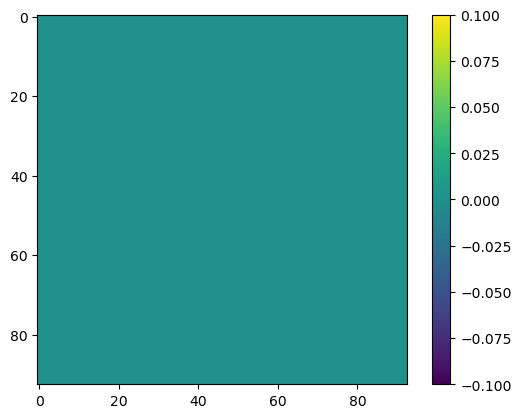

In [21]:
plt.imshow(dist_mats['FlagRep'])
plt.colorbar()

x, y

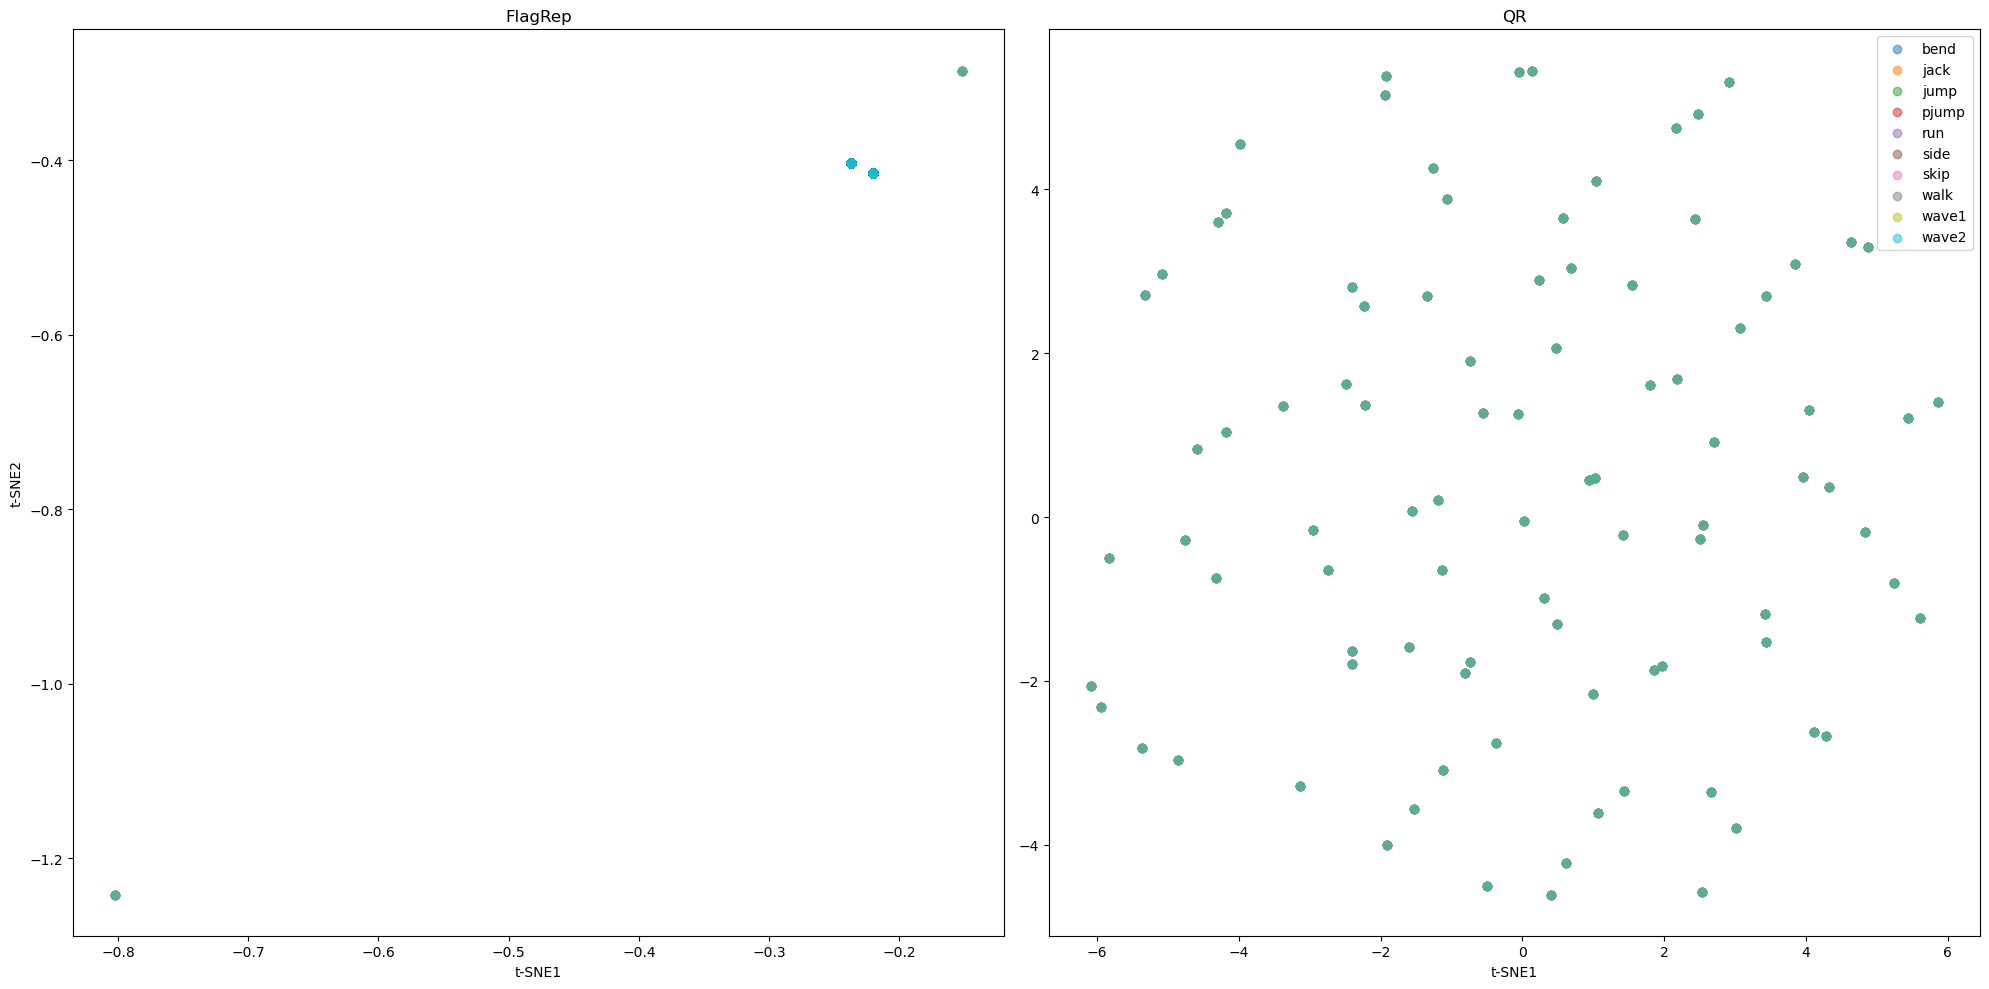

In [17]:
fig,ax = plt.subplots(1,2, figsize = (20,10))

for i, method_name in enumerate(['FlagRep', 'QR']):
    tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
    vis_data = tsne.fit_transform(dist_mats[method_name])
    for class_name in np.unique(mod_labels):
        scatter = ax[i].scatter(vis_data[:,0], vis_data[:,1], alpha=.5, label = class_name)
    ax[i].set_xlabel('t-SNE1')
    ax[i].set_title(method_name)
ax[0].set_ylabel('t-SNE2')
# Create a legend with labels
plt.legend()
plt.tight_layout()
plt.show()